# YEAST PPI 


### PIPELINE OVERVIEW
+ graph with genes as nodes and edges
+ generate a matrix from nodes based on specific parameters (features, random walk, shortest path..)
+ multidimensional matrices > embedding with tsne into 2D or 3D 
----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE 
______________

In [1]:
from multidimvis_main import *

In [2]:
data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

Counter(data['Interaction Detection Method'])
Counter(data['Interaction Types'])

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)

# ESSENTIAL GENES 
cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
essential_cere = cere_gene[(cere_gene['essentiality status'] == 'E')]
essential_genes_cere_list =  essential_cere['symbols'].tolist()

degree= dict(G_cere.degree())

mg = mygene.MyGeneInfo()
a = mg.querymany(essential_genes_cere_list, scopes='symbol', species=559292)
essential_genes_cere_names = pd.DataFrame.from_dict(a)
essential_genes_cere_entrez =  essential_genes_cere_names['entrezgene'].tolist()

cleaned_entrez_list = [x for x in essential_genes_cere_entrez if str(x) != 'nan']

degree_formatted={}
for k, v in degree.items():
    degree_formatted[k.replace("entrez gene/locuslink:","")] = v
    
index= []
essential = []
for i in cleaned_entrez_list:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            essential.append(val)  

no_essential_cere = cere_gene[(cere_gene['essentiality status'] == 'NE')]
no_essential_genes_cere_list =  no_essential_cere['symbols'].tolist()
b = mg.querymany(no_essential_genes_cere_list, scopes='symbol', species=559292)
no_essential_genes_cere_names = pd.DataFrame.from_dict(b)
no_essential_genes_cere_entrez =  no_essential_genes_cere_names['entrezgene'].tolist()
cleaned_entrez_list_no = [x for x in no_essential_genes_cere_entrez if str(x) != 'nan']

index= []
no_essential = []
for i in cleaned_entrez_list_no:
    for (key, val) in degree_formatted.items():
        if i==key:
            index.append(key)
            no_essential.append(val)
            
df_cere = pd.DataFrame({'essential': pd.Series(essential), 'no_essential': pd.Series(no_essential)})


no_ess_id = no_essential_genes_cere_names['entrezgene']
ess_id = essential_genes_cere_names['entrezgene']
G = G_cere

querying 1-1000...done.
querying 1001-1037...done.
Finished.
15 input query terms found no hit:
	['nan', 'YGR251W', 'YHR122W', 'TID3', 'YJR141W', 'YLR099W-A', 'MDN1', 'YLR132C', 'YLR243W', 'YMR134W
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4543...done.
Finished.
1 input query terms found dup hits:
	[('IMP2', 2)]
311 input query terms found no hit:
	['FLP1', 'REP1', 'RAF1', 'REP2', 'YAL018C', 'YAL044W-A', 'AIM1', 'YAL064C-A', 'YBL010C', 'YBL059W', 
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


# GRAPH PROPERTIES

In [3]:
degs = dict(G.degree())

print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 5785
Number of edges: 31237
Network density: 0.2%


#### Degree Distribution 

Degree min: 1
Degree max: 452
Degree Mean: 10.799308556611928
Degree Variant: 391.39982666105897


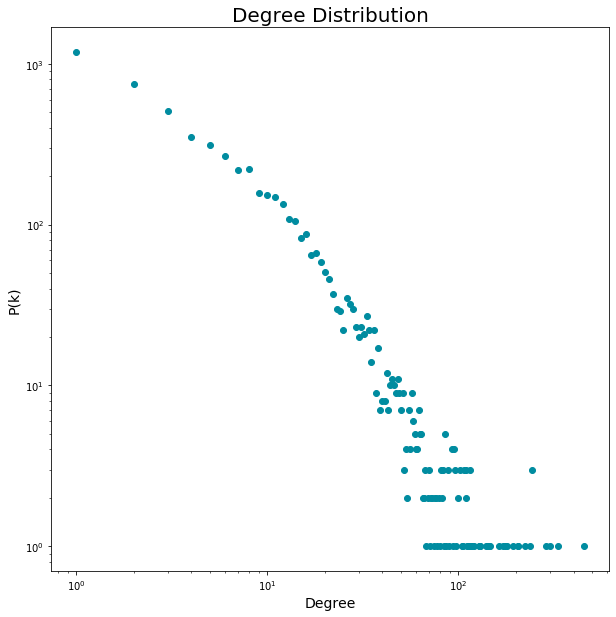

In [4]:
l_k = list(degs.values())
set_k = set(l_k)
print('Degree min:', min(l_k))
print('Degree max:', max(l_k))

d_k_f = {}
for k in set_k:
    d_k_f[k] = l_k.count(k)
#print('Degree counts:',d_k_f)

mean_deg = np.mean(l_k)
var_deg = np.var(l_k)
print('Degree Mean:', mean_deg)
print('Degree Variant:', var_deg)

plt.figure(figsize=(10,10))
plt.title('Degree Distribution', fontsize = 20)
plt.xlabel('Degree', fontsize = 14)
plt.ylabel('P(k)', fontsize = 14)
plt.loglog(list(d_k_f.keys()),list(d_k_f.values()),'o',c='#008CA0')
plt.show()

#plt.savefig('PPIdegreedist.png')

# FEATURE COLLECTION - Topological+Functional

#### + TOPOLOGICAL FEATURES
##### based on: https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html
+ degree centrality
+ closeness centrality
+ betweeness centrality
+ eigenvector centrality

In [ ]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)

In [ ]:
# CLOSENESS CENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)

In [ ]:
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)

In [ ]:
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)

### Score System

In [ ]:
# Hub Score - additional parameter to emphasize hub qualities of nodes

#cutoff = 4 # number of considered hub nodes 
#d_hubscored = calc_hub_score(G, degs, closeness, betweens, cutoff)

In [ ]:
# Essentiality Score - additional parameter to emphasize essentiality of nodes

essentials = []
for i in ess_id:
    essentials.append('entrez gene/locuslink:'+str(i))
    
nonessentials = []
for i in no_ess_id:
    nonessentials.append('entrez gene/locuslink:'+str(i))
    
major_score = 1
minor_score = 0.5 

d_essentiality_scores = node_essentiality_scores(G, essentials, nonessentials, major_score, minor_score)
d_essentiality_scores_sorted = {key:d_essentiality_scores[key] for key in G.nodes()}

### Feature Collection

In [ ]:
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}
d_essentiality_scores_sorted = {key:d_essentiality_scores[key] for key in sorted(d_essentiality_scores.keys())}


# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                     d_essentiality_scores_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                       'essent',
                                                                                      ]) 


l_features = [] 
for i in feature_dict_sorted.items():
    k = list(i)
    l_features.append(k)

In [ ]:
feature_df.head()

### Matrix Calculations (timed)

In [ ]:
%%time

A = nx.adjacency_matrix(G)
DM_adj = A.toarray()

In [ ]:
%%time

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = nx.shortest_path_length(G,geneA,geneB)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl = Mspl 

In [ ]:
%%time


# Restart probability
r = .8 # originally 0.8

alpha = 1.0 # indicating "randomness" 

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
DM_m_mod = np.array([(1-(x/max(x))) for x in DM_m])

In [ ]:
%%time
min_log = lambda t: -np.log(t)
DM_mlog = np.array([min_log(x/max(x)) for x in DM_m])

In [ ]:
%%time
DM_cos = distance.squareform(distance.pdist(feature_df, 'cosine'))

In [ ]:
%%time
DM_eucl = distance.squareform(distance.pdist(feature_df, 'euclidean'))

In [ ]:
%%time
DM_sqeucl = distance.squareform(distance.pdist(feature_df, 'sqeuclidean'))

In [ ]:
%%time
DM_corr = distance.squareform(distance.pdist(feature_df, 'correlation'))

#### EXPORT MATRICES TO CSV

In [ ]:
'''organism = 'Yeast'

df_adj = pd.DataFrame(DM_adj, columns = list(G.nodes()), index=list(G.nodes()))
df_spl = pd.DataFrame(DM_spl, columns = list(G.nodes()), index=list(G.nodes()))
df_m = pd.DataFrame(DM_m_mod, columns = list(G.nodes()), index=list(G.nodes()))
df_mlog = pd.DataFrame(DM_mlog, columns = list(G.nodes()), index=list(G.nodes()))

df_cos = pd.DataFrame(DM_cos, columns = list(G.nodes()), index=list(G.nodes()))
df_eucl = pd.DataFrame(DM_eucl, columns = list(G.nodes()), index=list(G.nodes()))
df_sqeucl = pd.DataFrame(DM_sqeucl, columns = list(G.nodes()), index=list(G.nodes()))
df_corr = pd.DataFrame(DM_corr, columns = list(G.nodes()), index=list(G.nodes()))

# -----------------------------------------------


# Without Score
df_adj.to_csv(r'output_csv/Adjacency_Dataframe_'+organism+'.csv', index = True)
df_spl.to_csv(r'output_csv/SPL_Dataframe_'+organism+'.csv', index = True)
df_m.to_csv(r'output_csv/RWR_Dataframe_'+organism+'.csv', index = True)
df_mlog.to_csv(r'output_csv/RWRlog_Dataframe_'+organism+'.csv', index = True)

df_cos.to_csv(r'output_csv/PW_cos_Dataframe_'+organism+'.csv', index = True)
df_eucl.to_csv(r'output_csv/PW_eucl_Dataframe_'+organism+'.csv', index = True)
df_sqeucl.to_csv(r'output_csv/PW_sqeucl_Dataframe_'+organism+'.csv', index = True)
df_corr.to_csv(r'output_csv/PW_corr_Dataframe_'+organism+'.csv', index = True)


# With Score
df_adj.to_csv(r'output_csv/Adjacency_Dataframe_'+organism+'_score.csv', index = True)
df_spl.to_csv(r'output_csv/SPL_Dataframe_'+organism+'_score.csv', index = True)
df_m.to_csv(r'output_csv/RWR_Dataframe_'+organism+'_score.csv', index = True)
df_mlog.to_csv(r'output_csv/RWRlog_Dataframe_'+organism+'_score.csv', index = True)

df_cos.to_csv(r'output_csv/PW_cos_Dataframe_'+organism+'_score.csv', index = True)
df_eucl.to_csv(r'output_csv/PW_eucl_Dataframe_'+organism+'_score.csv', index = True)
df_sqeucl.to_csv(r'output_csv/PW_sqeucl_Dataframe_'+organism+'_score.csv', index = True)
df_corr.to_csv(r'output_csv/PW_corr_Dataframe_'+organism+'_score.csv', index = True)
'''

#### IMPORT MATRICES (dataframe) FROM CSV

In [5]:
# without Score

DM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast.csv', index_col=0)
DM_spl = pd.read_csv('output_csv/SPL_Dataframe_Yeast.csv', index_col=0)
DM_m_mod = pd.read_csv('output_csv/RWR_Dataframe_Yeast.csv', index_col=0)
DM_mlog = pd.read_csv('output_csv/RWRlog_Dataframe_Yeast.csv', index_col=0)
DM_cos = pd.read_csv('output_csv/PW_cos_Dataframe_Yeast.csv', index_col=0)
DM_eucl = pd.read_csv('output_csv/PW_eucl_Dataframe_Yeast.csv', index_col=0)
DM_sqeucl = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast.csv', index_col=0)
DM_corr = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast.csv', index_col=0)

'''
# with Score

DM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast_score.csv', index_col=0)
DM_spl = pd.read_csv('output_csv/SPL_Dataframe_Yeast_score.csv', index_col=0)
DM_m_mod = pd.read_csv('output_csv/RWR_Dataframe_Yeast_score.csv', index_col=0)
#DM_mlog = pd.read_csv('output_csv/RWRlog_Dataframe_Yeast_score.csv', index_col=0)
DM_cos = pd.read_csv('output_csv/PW_cos_Dataframe_Yeast_score.csv', index_col=0)
DM_eucl = pd.read_csv('output_csv/PW_eucl_Dataframe_Yeast_score.csv', index_col=0)
DM_sqeucl = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast_score.csv', index_col=0)
DM_corr = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast_score.csv', index_col=0)
'''

"\n# with Score\n\nDM_adj = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast_score.csv', index_col=0)\nDM_spl = pd.read_csv('output_csv/SPL_Dataframe_Yeast_score.csv', index_col=0)\nDM_m_mod = pd.read_csv('output_csv/RWR_Dataframe_Yeast_score.csv', index_col=0)\n#DM_mlog = pd.read_csv('output_csv/RWRlog_Dataframe_Yeast_score.csv', index_col=0)\nDM_cos = pd.read_csv('output_csv/PW_cos_Dataframe_Yeast_score.csv', index_col=0)\nDM_eucl = pd.read_csv('output_csv/PW_eucl_Dataframe_Yeast_score.csv', index_col=0)\nDM_sqeucl = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast_score.csv', index_col=0)\nDM_corr = pd.read_csv('output_csv/Adjacency_Dataframe_Yeast_score.csv', index_col=0)\n"

____________
# 2D

### GENERAL Visualization Settings
+ NODE SIZE + NODES/EDGES COLOURS (essentiality)

In [6]:
ess_col = 'mediumblue' # 'rgba(5, 42, 128, 0.6)'
no_ess_col = 'lightblue' #'rgba(93, 140, 248, 0.6)'

essentials = list(ess_id)
nonessentials = list(no_ess_id)

colours = color_essentiality_nodes(G, essentials, nonessentials, ess_col, no_ess_col)
edge_color = color_essentiality_edges(G, essentials, nonessentials, ess_col, no_ess_col)

opacity_nodes = 0.6
opacity_edges = 0.05
node_edge_col = 'k'

In [7]:
organism = 'yeast'

node_factor = 1
size = draw_node_degree(G, node_factor) # node size based on degree
#size = 15

### EMBEDDING 2D

In [8]:
prplxty = 50 # range: 5-50 / default = 30.
density = 1.2  # default 12.
l_rate = 1000 # default 200.
steps = 250 # min 250

+ embedding (timed)

In [ ]:
%%time
# Spring

#forceatlas2 = ForceAtlas2()
#posG_spring = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)

posG_spring = nx.spring_layout(G)

In [ ]:
%%time
embed_adj = embed_tsne_2D(DM_adj, prplxty, density, l_rate, steps)
posG_adj = get_posG(G,embed_adj)

In [ ]:
%%time
embed_spl = embed_tsne_2D(DM_spl, prplxty, density, l_rate, steps)
posG_spl = get_posG(G,embed_spl)

In [ ]:
%%time
embed_m = embed_tsne_2D(DM_m_mod, prplxty, density, l_rate, steps)
posG_m = get_posG(G,embed_m)

In [ ]:
%%time
embed_mlog = embed_tsne_2D(DM_mlog, prplxty, density, l_rate, steps)
posG_mlog = get_posG(G,embed_mlog)

In [ ]:
%%time
embed_cos = embed_tsne_2D(DM_cos, prplxty, density, l_rate, steps)
posG_cos = get_posG(G,embed_cos)

In [11]:
%%time
embed_eucl = embed_tsne_2D(DM_eucl, prplxty, density, l_rate, steps)
posG_eucl = get_posG(G,embed_eucl)

CPU times: user 14.9 s, sys: 540 ms, total: 15.5 s
Wall time: 15.5 s


In [ ]:
%%time
embed_sqeucl = embed_tsne_2D(DM_sqeucl, prplxty, density, l_rate, steps)
posG_sqeucl = get_posG(G,embed_sqeucl)

In [ ]:
%%time
embed_corr = embed_tsne_2D(DM_corr, prplxty, density, l_rate, steps)
posG_corr = get_posG(G,embed_corr)

#### 2D SPRING

In [ ]:
plt.figure(figsize=(18,18))
plt.title('Organic spring', size=16)
plt.xlabel('x - axis', fontsize=16)
plt.ylabel('y - axis', fontsize=16)

nx.draw_networkx_nodes(G, posG_spring,
                       edgecolors = node_edge_col, 
                       linewidths = 0.5, 
                       node_color=colours, node_size=size)
nx.draw_networkx_edges(G, pos = posG_spring, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_spring, font_size = fontsize_labels, font_color = 'black')

print('Network: ', organism)
print('Number of Nodes:', len(G.nodes()))

plt.savefig('output_plots/Organic_spring_layout2D_'+organism+'.png')
plt.show()

#### 2D PORTRAITS

In [ ]:
print('Network: ', organism)
print('Number of nodes:', len(G.nodes()))
print('')
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)


plt.figure(figsize=(35,35))

plt.subplot(441)
plt.title('Adjacency + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_adj, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_adj, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_adj, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(442)
plt.title('Shortest Path length + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_spl, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_spl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_spl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(443)
plt.title('Markov + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

nx.draw_networkx_nodes(G, posG_m, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_m, width = 1., edge_color = 'lightgrey', alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_m, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(444)
plt.title('-log Markov + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_mlog, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_mlog, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_mlog, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/matrices_4x4_01'+ organism +'.png')
plt.show()


# 4 Plots
plt.figure(figsize=(35,35))

plt.subplot(441)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Cosine + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_cos, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_cos, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_cos, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(442)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Euclidean + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_eucl, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_eucl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_eucl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(443)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Squared euclidean + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_sqeucl, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_sqeucl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_sqeucl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


plt.subplot(444)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('Correlation matrix + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_corr, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, node_size=size)#, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_corr, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_corr, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/matrices_4x4_2'+ organism +'.png')
plt.show()

In [ ]:
node_factor = 2.5
size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('Adj + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_adj, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_adj, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_adj, font_size = fontsize_labels, font_color = 'black')

plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_adj_'+organism+'.png')

plt.show()

In [ ]:
#node_factor = 2.5
#size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('SPL + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_spl, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_spl, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_spl, font_size = fontsize_labels, font_color = 'black')

plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_spl_'+organism+'.png')

plt.show()

In [ ]:
#node_factor = 1.0
#size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('Markov + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_m, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_m, width = 1., edge_color = edge_color, alpha = opacity_edges)
#nx.draw_networkx_labels(G, pos = posG_eucl, font_size = fontsize_labels, font_color = 'black')
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_markov_'+organism+'.png')

plt.show()

In [ ]:
#node_factor = 1.0
#size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))

plt.title('Markov -log + t-SNE', size=16)
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')

nx.draw_networkx_nodes(G, posG_mlog, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_mlog, width = 1., edge_color = edge_color, alpha = opacity_edges)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_mlog_'+ organism +'.png')

plt.show()

In [ ]:
#node_factor = 1.0
#size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Cosine + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_cos, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_cos, width = 1., edge_color = edge_color, alpha = opacity_edges)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_cos_'+organism+'.png')

plt.show()

In [ ]:
#node_factor = 1.0
#size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist euclidean + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_eucl, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_eucl, width = 1., edge_color = edge_color, alpha = opacity_edges)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_eucl_'+organism+'.png')

plt.show()

In [ ]:
#node_factor = 1.0
#size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Squared euclidean + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_sqeucl, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_sqeucl, width = 1., edge_color = edge_color, alpha = opacity_edges)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_sqeucl_'+organism+'.png')

plt.show()

In [ ]:
#node_factor = 1.0
#size = draw_node_degree(G, node_factor) # node size based on degree

plt.figure(figsize=(25,25))
plt.xlabel('tsne comp1')
plt.ylabel('tsne comp2')
plt.title('PDist Correlation + t-SNE', size=16)

nx.draw_networkx_nodes(G, posG_corr, edgecolors = 'k', linewidths = 0.5, node_color=colours, node_size=size, alpha = opacity_nodes)
nx.draw_networkx_edges(G, pos = posG_corr, width = 1., edge_color = edge_color, alpha = opacity_edges)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig('output_plots/2D_corr_'+organism+'.png')

plt.show()

### LANDSCAPES

In [101]:
z_list = draw_node_degree_3D(G, node_factor) # node size based on degree

In [ ]:
d_essentiality_score

In [29]:
def draw_node_degree_3D_temp(G, scalef):
    x = 20
    ring_frac = (x-1.)/x

    l_size = []
    for node in G.nodes():
        k = nx.degree(G, node)
        R = scalef * (1+k**1.5)
        r = ring_frac * R
        l_size.append(r)
        
    l_size_n = []
    for i in l_size:
        j = np.sqrt(np.sqrt(i/max(l_size)))
        l_size_n.append(j*scalef)
        
    return l_size_n

In [75]:
node_factor = 30 # node size factor
size3d = draw_node_degree_3D_temp(G, node_factor) # node size based on degree
#size3d = 5

In [ ]:
%%time

adj_x, adj_y, adj_z = get_coords_landscape(G, posG_adj)
adj_trace, adj_trace_z = get_trace_nodes_landscape(adj_x, adj_y, adj_z, z_list, colours, size3d)
#adj_edges = get_trace_edges_Z(adj_x, adj_y, adj_z, z_list)
data_adj = [adj_trace, adj_trace_z,adj_edges]

spl_x, _spl_y, spl_z = get_coords_landscape(G,posG_spl)
spl_trace, spl_trace_z = get_trace_nodes_landscape(spl_x, _spl_y, spl_z, z_list, colours, size3d)
#spl_edges = get_trace_edges_Z(spl_x, _spl_y, spl_z, z_list)
data_spl = [spl_trace, spl_trace_z, spl_edges]

m_x, m_y, m_z = get_coords_landscape(G,posG_m)
m_trace, m_trace_z = get_trace_nodes_landscape(m_x, m_y, m_z, z_list, colours, size3d)
#m_edges = get_trace_edges_Z(m_x, m_y, m_z, z_list)
data_m = [m_trace, m_trace_z,m_edges]

mlog_x, mlog_y, mlog_z = get_coords_landscape(G,posG_mlog)
mlog_trace, mlog_trace_z = get_trace_nodes_landscape(mlog_x, mlog_y, mlog_z, z_list, colours, size3d)
#mlog_edges = get_trace_edges_Z(mlog_x, mlog_y, mlog_z, z_list)
data_mlog = [mlog_trace, mlog_trace_z,mlog_edges]

In [ ]:
%%time 


cos_x, cos_y, cos_z = get_coords_landscape(G, posG_cos)
cos_trace, cos_trace_z = get_trace_nodes_landscape(cos_x, cos_y, z_list, colours, size3d)
#cos_edges = get_trace_edges_Z(cos_x, cos_y, cos_z, z_list)
data_cos = [cos_trace_z] #,cos_edges]

eucl_x, eucl_y, eucl_z = get_coords_landscape(G, posG_eucl)
eucl_trace, eucl_trace_z = get_trace_nodes_landscape(eucl_x, eucl_y, z_list, colours, size3d)
#eucl_edges = get_trace_edges_Z(eucl_x, eucl_y, eucl_z, z_list)
data_eucl = [eucl_trace_z] #,eucl_edges]

sqeucl_x, sqeucl_y, sqeucl_z = get_coords_landscape(G, posG_sqeucl)
sqeucl_trace, sqeucl_trace_z = get_trace_nodes_landscape(sqeucl_x, sqeucl_y, z_list, colours, size3d)
#sqeucl_edges = get_trace_edges_Z(sqeucl_x, sqeucl_y, eucl_z, z_list)
data_sqeucl = [sqeucl_trace_z] #,sqeucl_edges]

corr_x, corr_y, corr_z = get_coords_landscape(G, posG_corr)
corr_trace, corr_trace_z = get_trace_nodes_landscape(corr_x, corr_y, z_list, colours, size3d)
#corr_edges = get_trace_edges_Z(corr_x, corr_y, corr_z, z_list)
data_corr = [corr_trace_z] #,corr_edges]

In [ ]:
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)


fig_1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency + t-SNE', 
                                                     'SPL + t-SNE',
                                                     'Markov + t-SNE',
                                                     'Markov -log + t-SNE',
                                                      )
                    )

    
for i in data_adj:
    fig_1.add_trace(i, row = 1, col = 1)
    
for i in data_spl:
    fig_1.add_trace(i, row = 1, col = 2)
    
for i in data_m:
    fig_1.add_trace(i, row = 1, col = 3)

for i in data_mlog:
    fig_1.add_trace(i, row = 1, col = 4)
py.iplot(fig_1)

plotly.offline.plot(fig_1, filename = 'output_plots/Landscapes_01_' + organism + '.html', auto_open=False)

In [ ]:
print('Perplexity:', prplxty)
print('Early Exaggeration:', density)
print('Learning rate:', l_rate)
print('Iterations:', steps)


fig_2 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Cosine + t-SNE', 
                                                     'Euclidean + t-SNE', 
                                                     'Squared Euclidean + t-SNE',
                                                     'Correlation + t-SNE')
                    )

for i in data_cos:
    fig_2.add_trace(i, row = 1, col = 1)
    
for i in data_eucl:
    fig_2.add_trace(i, row = 1, col = 2)
    
for i in data_sqeucl:
    fig_2.add_trace(i, row = 1, col = 3)

for i in data_corr:
    fig_2.add_trace(i, row = 1, col = 4)

fig_2.update_layout(template='none', showlegend = False, width = 2000, height = 800)
py.iplot(fig_2)

plotly.offline.plot(fig_2, filename = 'output_plots/Landscapes_02_'+organism+'.html', auto_open=False)

In [ ]:
# export coordinates for landscape 

____________
# 3D

### 3D Visualization Settings

In [ ]:
%%time 

#node_factor = 15
#size3d = draw_node_degree_3D(G, node_factor) # node size based on degree 
# for 3D best values are between 1-15

size3d = 3

In [ ]:
edge_color_3d = []
for i in edge_color:
    edge_color_3d.append(i)
    edge_color_3d.append(i)
    edge_color_3d.append(0)
    
edge_color = edge_color_3d

### EMBEDDING 3D Portraits

In [ ]:
prplxty3d = 50 # range: 5-50 / default = 30.#
density3d = 1.2 # default 12.
l_rate3d = 1000 # default 200.
steps3d = 250 #min 250

l_features = None 

In [ ]:
%%time 

#Fruchterman-Reingold force-directed algorithm
posG3d_spring = nx.spring_layout(G, dim=3)

In [ ]:
%%time
posG3d_adj = embed_tsne_3D(G, DM_adj, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time
posG3d_spl = embed_tsne_3D(G, DM_spl, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time 
posG3d_m = embed_tsne_3D(G, DM_m_mod, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time
posG3d_mlog = embed_tsne_3D(G, DM_mlog, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time
posG3d_cos = embed_tsne_3D(G, DM_cos, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time
posG3d_eucl = embed_tsne_3D(G, DM_eucl, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time
posG3d_sqeucl = embed_tsne_3D(G, DM_sqeucl, prplxty3d, density3d, l_rate3d, steps3d)

In [ ]:
%%time
posG3d_corr = embed_tsne_3D(G, DM_corr, prplxty3d, density3d, l_rate3d, steps3d)

### 3D Portraits | EXPORT Coordinates x,y,z,rgba

In [ ]:
'''
organism = 'Yeast'


colours_rgba = []
for i in colours: 
    if i == ess_col:
        colours_rgba.append('rgba(5, 42, 128, 0.6)')
    elif i == no_ess_col:
        colours_rgba.append('rgba(93, 140, 248, 0.6)')
    else:
        colours_rgba.append('rgba(0,0,0,0.4)')
        
        
df_xyz_rgba_3Dspring = pd.DataFrame(posG3d_spring, index=["x","y","z"]).T
df_xyz_rgba_3Dspring['color'] = colours_rgba

df_xyz_rgba_3Dadj = pd.DataFrame(posG3d_adj, index=["x","y","z"]).T
df_xyz_rgba_3Dadj['color'] = colours_rgba

df_xyz_rgba_3Dspl = pd.DataFrame(posG3d_spl, index=["x","y","z"]).T
df_xyz_rgba_3Dspl['color'] = colours_rgba

df_xyz_rgba_3Dm = pd.DataFrame(posG3d_m, index=["x","y","z"]).T
df_xyz_rgba_3Dm['color'] = colours_rgba

df_xyz_rgba_3Dmlog = pd.DataFrame(posG3d_mlog, index=["x","y","z"]).T
df_xyz_rgba_3Dmlog['color'] = colours_rgba


df_xyz_rgba_3Dcos = pd.DataFrame(posG3d_cos, index=["x","y","z"]).T
df_xyz_rgba_3Dcos['color'] = colours_rgba

df_xyz_rgba_3Deucl = pd.DataFrame(posG3d_eucl, index=["x","y","z"]).T
df_xyz_rgba_3Deucl['color'] = colours_rgba

df_xyz_rgba_3Dsqeucl = pd.DataFrame(posG3d_sqeucl, index=["x","y","z"]).T
df_xyz_rgba_3Dsqeucl['color'] = colours_rgba

df_xyz_rgba_3Dcorr = pd.DataFrame(posG3d_corr, index=["x","y","z"]).T
df_xyz_rgba_3Dcorr['color'] = colours_rgba


# -----------------------------------------------

df_xyz_rgba_spring.to_csv(r'output_csv/3Dspring_XYZ_RGBA_'+organism+'.csv', index = True)

df_xyz_rgba_3Dadj.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_Adjacency_'+organism+'.csv', index = True)
df_xyz_rgba_3Dspl.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_SPL_'+organism+'.csv', index = True)
df_xyz_rgba_3Dm.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_RWR_'+organism+'.csv', index = True)
df_xyz_rgba_3Dmlog.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_RWRlog_'+organism+'.csv', index = True)


df_xyz_rgba_3Dcos.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_PW_cos_'+organism+'.csv', index = True)
df_xyz_rgba_3Deucl.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_PW_eucl_'+organism+'.csv', index = True)
df_xyz_rgba_3Dsqeucl.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_PW_sqeucl_'+organism+'.csv', index = True)
df_xyz_rgba_3Dcorr.to_csv(r'output_csv/3Dportrait_XYZ_RGBA_PW_corr_'+organism+'.csv', index = True)
'''

### TRACES (timed) 

In [ ]:
%%time 

adj_edges = get_trace_edges(G, posG3d_adj, edge_color) 
adj_nodes = get_trace_nodes(G, posG3d_adj,  l_features, colours, size3d)
data_adj = [adj_edges, adj_nodes]

In [ ]:
%%time 

spl_edges = get_trace_edges(G, posG3d_spl, edge_color) 
spl_nodes = get_trace_nodes(G, posG3d_spl,  l_features, colours, size3d)
data_spl = [spl_edges, spl_nodes]

In [ ]:
%%time

m_edges = get_trace_edges(G, posG3d_m, edge_color) 
m_nodes = get_trace_nodes(G, posG3d_m, l_features, colours, size3d)
data_m = [m_edges, m_nodes]

In [ ]:
%%time

mlog_edges = get_trace_edges(G, posG3d_mlog, edge_color) 
mlog_nodes = get_trace_nodes(G, posG3d_mlog, l_features, colours, size3d)
data_mlog = [mlog_edges, mlog_nodes]

In [ ]:
%%time

cos_edges = get_trace_edges(G, posG3d_cos, edge_color) 
cos_nodes = get_trace_nodes(G, posG3d_cos, l_features, colours, size3d)
data_cos = [cos_edges, cos_nodes]

In [ ]:
%%time

eucl_edges = get_trace_edges(G, posG3d_eucl, edge_color) 
eucl_nodes = get_trace_nodes(G, posG3d_eucl,l_features, colours, size3d)
data_eucl = [eucl_edges, eucl_nodes]

In [ ]:
%%time

sqeucl_edges = get_trace_edges(G, posG3d_sqeucl, edge_color) 
sqeucl_nodes = get_trace_nodes(G, posG3d_sqeucl, l_features, colours, size3d)
data_sqeucl = [sqeucl_edges, sqeucl_nodes]

In [ ]:
%%time

corr_edges = get_trace_edges(G, posG3d_corr, edge_color) 
corr_nodes = get_trace_nodes(G, posG3d_corr, l_features, colours, size3d)
data_corr = [corr_edges, corr_nodes]

In [ ]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)


fig1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency + t-SNE', 
                                                     'SPL + t-SNE',
                                                     'Markov + t-SNE',
                                                     'Markov -log + t-SNE')
                    )

    
for i in data_adj:
    fig1.add_trace(i, row = 1, col = 1)
    
for i in data_spl:
    fig1.add_trace(i, row = 1, col = 2)
    
for i in data_m:
    fig1.add_trace(i, row = 1, col = 3)

for i in data_mlog:
    fig1.add_trace(i, row = 1, col = 4)

fig1.update_layout(template='none', showlegend = False, width = 2000, height = 800)
py.iplot(fig1)

plotly.offline.plot(fig1, filename = 'output_plots/3Dmatrices_1_'+organism+'.html', auto_open=False)

In [ ]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)


fig2 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Cosine + t-SNE', 
                                                     'Euclidean + t-SNE', 
                                                     'Squared Euclidean + t-SNE',
                                                     'Correlation + t-SNE')
                    )

for i in data_cos:
    fig2.add_trace(i, row = 1, col = 1)
    
for i in data_eucl:
    fig2.add_trace(i, row = 1, col = 2)
    
for i in data_sqeucl:
    fig2.add_trace(i, row = 1, col = 3)

for i in data_corr:
    fig2.add_trace(i, row = 1, col = 4)

fig2.update_layout(template='none', showlegend = False, width = 2000, height = 800)
py.iplot(fig2)

plotly.offline.plot(fig2, filename = 'output_plots/3Dmatrices_2_'+organism+'.html', auto_open=False)

### 3D Spheres

In [ ]:
# tSNE optimization 

momentum = 0.1 # default 0.1
final_momentum = 0.9 # default 0.7
max_iter = 10
learning_rate = 1000
min_gain = 0.01

In [ ]:
%%time 

# EMBEDDING - matrix 1-4

embedded_adj = embed_tsne_sphere(G, DM_adj, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_spl = embed_tsne_sphere(G, DM_spl, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_m = embed_tsne_sphere(G, DM_m_mod, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_mlog = embed_tsne_sphere(G, DM_mlog, momentum, final_momentum, learning_rate, min_gain, max_iter)

In [ ]:
%%time 

# EMBEDDING - matrix 4-8

embedded_cos = embed_tsne_sphere(G, DM_cos, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_eucl = embed_tsne_sphere(G, DM_eucl, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_sqeucl = embed_tsne_sphere(G, DM_sqeucl, momentum, final_momentum, learning_rate, min_gain, max_iter)
embedded_corr = embed_tsne_sphere(G, DM_corr, momentum, final_momentum, learning_rate, min_gain, max_iter)

### SPHERES | EXPORT Coordinates x,y,z,rgba

In [ ]:
'''
organism = 'Yeast'


colours_rgba = []
for i in colours: 
    if i == ess_col:
        colours_rgba.append('rgba(5, 42, 128, 0.6)')
    elif i == no_ess_col:
        colours_rgba.append('rgba(93, 140, 248, 0.6)')
    else:
        colours_rgba.append('rgba(0,0,0,0.4)')
        

df_xyz_rgba_sphere_adj = pd.DataFrame(embedded_adj, index=["x","y","z"]).T
df_xyz_rgba_sphere_adj['color'] = colours_rgba

df_xyz_rgba_sphere_spl = pd.DataFrame(embedded_spl, index=["x","y","z"]).T
df_xyz_rgba_sphere_spl['color'] = colours_rgba

df_xyz_rgba_sphere_m = pd.DataFrame(embedded_m, index=["x","y","z"]).T
df_xyz_rgba_sphere_m['color'] = colours_rgba

df_xyz_rgba_sphere_mlog = pd.DataFrame(embedded_mlog, index=["x","y","z"]).T
df_xyz_rgba_sphere_mlog['color'] = colours_rgba



df_xyz_rgba_sphere_cos = pd.DataFrame(embedded_cos, index=["x","y","z"]).T
df_xyz_rgba_sphere_cos['color'] = colours_rgba

df_xyz_rgba_sphere_eucl = pd.DataFrame(embedded_eucl, index=["x","y","z"]).T
df_xyz_rgba_sphere_eucl['color'] = colours_rgba

df_xyz_rgba_sphere_sqeucl = pd.DataFrame(embedded_sqeucl, index=["x","y","z"]).T
df_xyz_rgba_sphere_sqeucl['color'] = colours_rgba

df_xyz_rgba_sphere_corr = pd.DataFrame(embedded_corr, index=["x","y","z"]).T
df_xyz_rgba_sphere_corr['color'] = colours_rgba


# -----------------------------------------------

df_xyz_rgba_sphere_adj.to_csv(r'output_csv/3DSphere_XYZ_RGBA_Adjacency_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_spl.to_csv(r'output_csv/3DSphere_XYZ_RGBA_SPL'+organism+'.csv', index = True)
df_xyz_rgba_sphere_m.to_csv(r'output_csv/3DSphere_XYZ_RGBA_RWR_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_mlog.to_csv(r'output_csv/3DSphere_XYZ_RGBA_RWRlog_'+organism+'.csv', index = True)

df_xyz_rgba_sphere_cos.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_cos_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_eucl.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_eucl_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_sqeucl.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_sqeucl_'+organism+'.csv', index = True)
df_xyz_rgba_sphere_corr.to_csv(r'output_csv/3DSphere_XYZ_RGBA_PW_corr_'+organism+'.csv', index = True)
'''

In [ ]:
# choose radius parameter for layout

# dict param should be : {NODE ID: VALUE}
dict_param = d_essentiality_scores_sorted

d_node_rad = assign_radius_to_nodes(G, dict_param)  

l_rad = list(set(d_node_rad.values()))
spheres_back = get_sphere_background(l_rad)

In [ ]:
# TO DO : fix edges for spheres

'''%%time

posG = embedded_cos

edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    for node, rad in d_node_rad.items():
        for i, coords in posG.items():
            if node == i:
                x0, y0, z0 = posG[edge[0]][0]*rad,posG[edge[0]][1]*rad,posG[edge[0]][2]*rad
                x1, y1, z1 = posG[edge[1]][0]*rad,posG[edge[1]][1]*rad,posG[edge[1]][2]*rad
                edge_x.append(x0)
                edge_x.append(x1)
                edge_x.append(None)
                edge_y.append(y0)
                edge_y.append(y1)
                edge_y.append(None)
                edge_z.append(z0)
                edge_z.append(z1)
                edge_z.append(None)
                
trace_edge = pgo.Scatter3d(
            x = edge_x, 
            y = edge_y, 
            z = edge_z,
            mode = 'lines', hoverinfo='none',
            line = dict(width = 0.5, color = edge_color),
            opacity = 0.3
    )
'''

In [ ]:
%%time 


trace_nodes_adj = get_tsne_sphere_trace_nodes(embedded_adj, d_node_rad, colours, size3d)
#trace_edges_adj = get_trace_edges(G, embedded_adj, edge_color)
data_adj = [trace_nodes_adj] #, trace_edges_adj]


trace_nodes_spl = get_tsne_sphere_trace_nodes(embedded_spl, d_node_rad, colours, size3d)
data_spl = [trace_nodes_spl]

trace_nodes_m = get_tsne_sphere_trace_nodes(embedded_m, d_node_rad, colours, size3d)
data_m = [trace_nodes_m]

trace_nodes_mlog = get_tsne_sphere_trace_nodes(embedded_mlog, d_node_rad, colours, size3d)
data_mlog = [trace_nodes_mlog]

In [ ]:
%%time 

trace_nodes_cos = get_tsne_sphere_trace_nodes(embedded_cos, d_node_rad, colours, size3d)
#trace_edges_cos = get_trace_edges_withradius(G, embedded_cos, d_node_rad, edge_color)
data_cos = [trace_nodes_cos] #, trace_edges_cos]

trace_nodes_eucl = get_tsne_sphere_trace_nodes(embedded_eucl, d_node_rad, colours, size3d)
data_eucl = [trace_nodes_eucl]

trace_nodes_sqeucl = get_tsne_sphere_trace_nodes(embedded_sqeucl, d_node_rad, colours, size3d)
data_sqeucl = [trace_nodes_sqeucl]

trace_nodes_corr = get_tsne_sphere_trace_nodes(embedded_corr, d_node_rad, colours, size3d)
data_corr = [trace_nodes_corr]

In [ ]:
print('Momentum:', momentum)
print('Final Momentum:', final_momentum)
print('Max.Iterations:', max_iter)
print('Learning rate:', learning_rate)
print('Min.Gain:', min_gain)


fig_s1 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Adjacency + t-SNE', 
                                                     'SPL + t-SNE',
                                                     'Markov + t-SNE',
                                                     'Markov -log + t-SNE')
                    )

    
for i in data_adj:
    fig_s1.add_trace(i, row = 1, col = 1)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 1)
    
for i in data_spl:
    fig_s1.add_trace(i, row = 1, col = 2)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 2)
    
for i in data_m:
    fig_s1.add_trace(i, row = 1, col = 3)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 3)

for i in data_mlog:
    fig_s1.add_trace(i, row = 1, col = 4)
#for i in spheres_back: 
#    fig_s1.add_trace(i, row = 1, col = 4)
    
fig_s1.update_layout(template = "plotly_dark", height = 800, width = 2000)
fig_s1.update_xaxes(showgrid=False)
fig_s1.update_yaxes(showgrid=False)
py.iplot(fig_s1)

plotly.offline.plot(fig_s1, filename = 'output_plots/3Dmatrices_spheres1_'+organism+'.html', auto_open=False)

In [ ]:
print('Momentum:', momentum)
print('Final Momentum:', final_momentum)
print('Max.Iterations:', max_iter)
print('Learning rate:', learning_rate)
print('Min.Gain:', min_gain)


fig_s2 = make_subplots(rows = 1, cols = 4,
                    specs=[4 * [{'type': 'scatter3d'}]],
                    print_grid=False, subplot_titles=('Cosine + t-SNE', 
                                                     'Euclidean + t-SNE', 
                                                     'Squared Euclidean + t-SNE',
                                                     'Correlation + t-SNE')
                    )

for i in data_cos:
    fig_s2.add_trace(i, row = 1, col = 1)
#for i in spheres_back: 
#    fig_s2.add_trace(i, row = 1, col = 1)
    
for i in data_eucl:
    fig_s2.add_trace(i, row = 1, col = 2)
#for i in spheres_back: 
#    fig_s2.add_trace(i, row = 1, col = 2)
    
for i in data_sqeucl:
    fig_s2.add_trace(i, row = 1, col = 3)
#for i in spheres_back: 
#    fig_s2.add_trace(i, row = 1, col = 3)

for i in data_corr:
    fig_s2.add_trace(i, row = 1, col = 4)
#for i in spheres_back: 
#fig_s2.add_trace(i, row = 1, col = 4)

fig_s2.update_layout(template = "plotly_dark", height = 800, width = 2000)
fig_s2.update_xaxes(showgrid=False)
fig_s2.update_yaxes(showgrid=False)

py.iplot(fig_s2)

plotly.offline.plot(fig_s2, filename = 'output_plots/3Dmatrices_spheres2_'+organism+'.html', auto_open=False)